In [5]:
def Plot(X, Y):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.axis([-1,4,-1,4])
    ax.grid()
    ax.plot(X, Y)
    ax.scatter(X, Y)
    ax.plot(Target[0], Target[1], marker='x', ms=20, color='red')
    ax.text(X[0], Y[0]-0.4, 'Base', ha='center')
    ax.text(X[-1], Y[-1]+0.2, 'End Effector', ha='left')
    ax.text(Target[0], Target[1]-0.2, 'Target', ha='left', va='top', color='red')


Target      :  x = 0.9 , y = 0.0
End-effector:  x = 0.9000063390884092 , y = 7.211339880797141e-06
Error(< 1e-5): 9.900425219305683e-06
Loops: 450
[0.7670880652975555, -2.530727415391778, -0.9148639153289807]


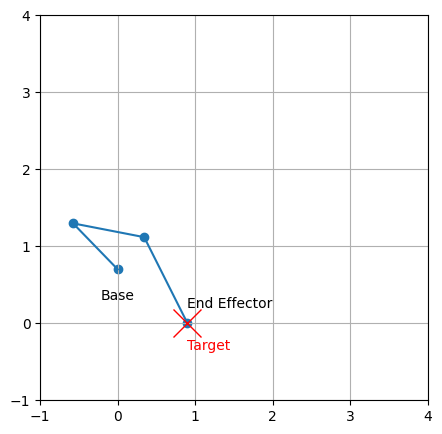

In [6]:
import numpy as np
from numpy.linalg import pinv, norm
import matplotlib.pyplot as plt

# ここに FK, Jacobian 関数の定義を追加
def Jacobian(L, TH):
    # 各関節の位置を計算
    x1 = L[0] * np.cos(TH[0] + np.pi / 2)
    y1 = L[0] * np.sin(TH[0] + np.pi / 2)
    x2 = x1 + L[1] * np.cos(TH[0] + TH[1] + np.pi / 2)
    y2 = y1 + L[1] * np.sin(TH[0] + TH[1] + np.pi / 2)
    x3 = x2 + L[2] * np.cos(TH[0] + TH[1] + TH[2] + np.pi / 2)
    y3 = y2 + L[2] * np.sin(TH[0] + TH[1] + TH[2] + np.pi / 2)

    # ヤコビアン行列の計算
    J = np.array([
        [-L[0]*np.sin(TH[0] + np.pi / 2) - L[1]*np.sin(TH[0] + TH[1] + np.pi / 2) - L[2]*np.sin(TH[0] + TH[1] + TH[2] + np.pi / 2), 
         -L[1]*np.sin(TH[0] + TH[1] + np.pi / 2) - L[2]*np.sin(TH[0] + TH[1] + TH[2] + np.pi / 2), 
         -L[2]*np.sin(TH[0] + TH[1] + TH[2] + np.pi / 2)],
        [ L[0]*np.cos(TH[0] + np.pi / 2) + L[1]*np.cos(TH[0] + TH[1] + np.pi / 2) + L[2]*np.cos(TH[0] + TH[1] + TH[2] + np.pi / 2), 
          L[1]*np.cos(TH[0] + TH[1] + np.pi / 2) + L[2]*np.cos(TH[0] + TH[1] + TH[2] + np.pi / 2), 
          L[2]*np.cos(TH[0] + TH[1] + TH[2] + np.pi / 2)]
    ])
    return J

def FK(L, TH, plot=False):
    # 各関節の角度を計算
    th1 = TH[0] + np.pi / 2
    th2 = TH[1] + TH[0] + np.pi / 2
    th3 = TH[2] + TH[1] + TH[0] + np.pi / 2

    # エンドエフェクタの位置を計算
    x0 = 0
    y0 = 0.7
    x1 = x0 + L[0] * np.cos(th1)
    y1 = y0 + L[0] * np.sin(th1)
    x2 = x1 + L[1] * np.cos(th2)
    y2 = y1 + L[1] * np.sin(th2)
    x3 = x2 + L[2] * np.cos(th3)
    y3 = y2 + L[2] * np.sin(th3)
    if plot:
        return [x0, x1, x2, x3], [y0, y1, y2, y3]
    else:
        return np.array([x3, y3])
# 角度の上限と下限を設定（例：-90度から90度）
TH_max = np.radians([105, 145, 105])  # 上限
TH_min = np.radians([-105, -145, -105])  # 下限

# 角度を制限範囲内に保つ関数
def limit_angles(TH, TH_min, TH_max):
    TH_limited = np.clip(TH, TH_min, TH_max)
    return TH_limited

# 初期パラメータ
L1 = 0.456 + 0.26 #base to link1 
L2 = 0.83 #link1 to link2
L3 = 0.935 #link2 to link3
L4 = 1.25 #link3 to link4

Target = np.array([0.9, 0])  # 目標位置
L = np.array([L2, L3, L4])  # リンクの長さ
TH = np.radians([0, 0, 0])  # 初期関節角度
scaler = 0.1  # スムーズな遷移のためのスケーラー
loops = 0  # ループカウンター

while True:
    J = Jacobian(L, TH)  # ヤコビアン行列を計算
    Err = Target - FK(L, TH, plot=False)  # 目標位置と現在のエンドエフェクタ位置の誤差
    dTheta = pinv(J, rcond=1e-15) @ Err.T  # 角度の変化量を計算

    # dThetaが1次元配列の場合、以下のように修正
    if dTheta.ndim == 1:
        TH += dTheta * scaler
    else:
        TH += dTheta[:, 0] * scaler  # 角度を更新

    # 角度を制限範囲内に保つ
    TH = limit_angles(TH, TH_min, TH_max)



    loops += 1
    #X, Y = FK(L, TH, plot=True)
    #Plot(X, Y)
    ErrNorm = norm(Err)
    if ErrNorm < 1e-5:  # 誤差が非常に小さい場合、ループを終了
        X, Y = FK(L, TH, plot=True)
        Plot(X, Y)
        print('Target      :  x =', Target[0], ', y =', Target[1])
        print('End-effector:  x =', X[-1], ', y =', Y[-1])
        print('Error(< 1e-5):', ErrNorm)
        print('Loops:', loops)
        break

    if loops > 1000:  # ループ回数の上限に達した場合、ループを終了
        print('More than 1000 loops')
        break

        # 各イテレーションでの角度を表示
TH_deg = np.degrees(TH)  # ラジアンから度に変換
TH_rad = np.radians(TH_deg)  # 度からラジアンに変換

TH_rad_list = TH_rad.tolist()

print(TH_rad_list)